# Model Arima for Time Series Forecasting temperature

# LLibreries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

import json
import os

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Model ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from dateutil.relativedelta import relativedelta


# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

# Preparació de dades

In [2]:
# Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Data/Dades_T_estacions_xema_Z1'
fitxer_dades = 'SCM_T_Z1.json'

path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades)

# Obrir un arxiu json per veure com esta estructurat i com organitzar les dades
with open(path_dades, 'r') as f:
    data = json.load(f)

# Accedemos a las lecturas (temperaturas) del JSON
lecturas = data[0]['variables'][0]['lectures']

# Convertimos las lecturas a un DataFrame con solo las columnas necesarias
df = pd.DataFrame(lecturas)[['data', 'valor']]


# Convertimos la columna 'data' a tipo datetime para análisis posterior
df['data'] = pd.to_datetime(df['data'], utc=True)

df = df.sort_values(by='data')

# Eliminem les dades que estan entre hores, es a dir en minuts que no son 0
df = df[df['data'].dt.minute == 0]

# Restablir l'index
df = df.reset_index(drop=True)


# Construcció model ARIMA

In [3]:
# Definim el període de predicció

inici = "2021-01-01 00:00:00+00:00"  
final = "2021-01-02 00:00:00+00:00"  

# Definim finestra d'entrenament (quant de temps enrere volem mirar)

dies_entrenament = 4  # entrenarem amb 90 dies previs (3 mesos)


# Establim les dades d'entrenament i de test per l'ARIMA
data = df.copy()
display(data.head(5))

data_inici_pred = pd.to_datetime(inici)
data_final_pred = pd.to_datetime(final)

data_inici_train = data_inici_pred - pd.Timedelta(days=dies_entrenament)

# Conjunt d'entrenament
data_train = data[(data['data'] >= data_inici_train) & (data['data'] < data_inici_pred)].copy()
# Restablir l'index
data_train = data_train.reset_index(drop=True)

# Conjunt de test (el que volem predir)
data_test = data[(data['data'] >= data_inici_pred) & (data['data'] <= data_final_pred)].copy()
# Restablir l'index
data_test = data_test.reset_index(drop=True)


# Mostrem les dimensions
print(f"Dades d'entrenament: {len(data_train)} valors")
print(f"Dades de test: {len(data_test)} valors")


# # Grafiquem data_train i data_test en el mateix gràfic

# plt.figure(figsize=(15, 5))
# plt.plot(data_train['data'], data_train['valor'], label='Train')
# plt.plot(data_test['data'], data_test['valor'], label='Test')
# plt.xlabel("Data")
# plt.ylabel("Dades Temperatura")
# plt.title("Train i Test")
# plt.legend()
# plt.grid(True)
# plt.show()

,data,valor
0,1998-01-01 00:00:00+00:00,-4.60
1,1998-01-01 01:00:00+00:00,-5.10
2,1998-01-01 02:00:00+00:00,-5.30
3,1998-01-01 03:00:00+00:00,-5.50
4,1998-01-01 04:00:00+00:00,-5.80


Dades d'entrenament: 96 valors
Dades de test: 25 valors


,data,valor,forecast
0,2021-01-01 00:00:00+00:00,-7.40,-6.25
1,2021-01-01 01:00:00+00:00,-7.60,-5.72
2,2021-01-01 02:00:00+00:00,-7.70,-5.43
3,2021-01-01 03:00:00+00:00,-8.00,-5.28
4,2021-01-01 04:00:00+00:00,-8.40,-5.20


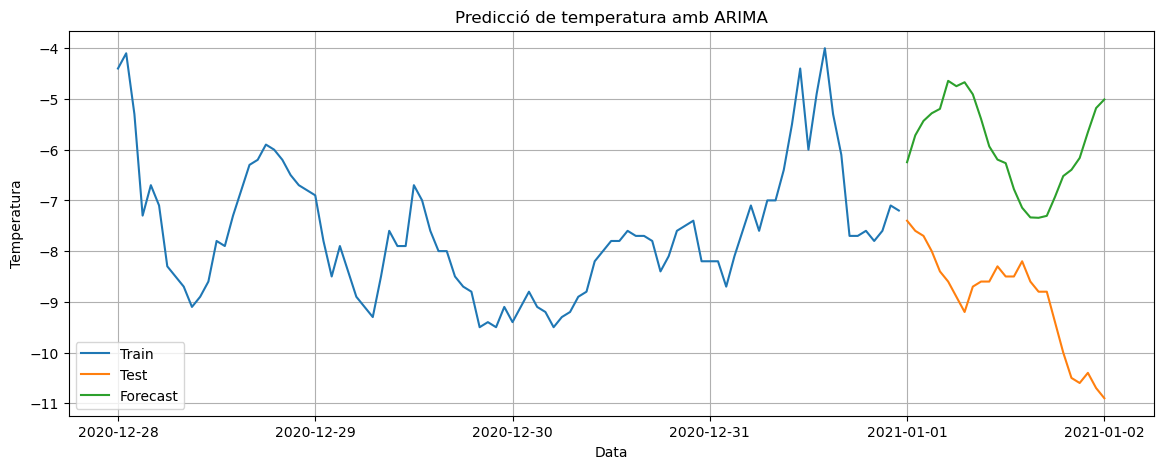

MAE: 3.02 °C
RMSE: 3.31 °C


In [4]:
# Parametres model  

p =  10      # Ordre autoregressiu
d =  1      # Ordre d'integració
q =  10     # Ordre de mitjana mòbil


# Entrenem amb statsmodels

model = ARIMA(data_train['valor'], order=(p, d, q))
model_fit = model.fit()

# print(model_fit.summary())


# Prediccions

data_test_p = data_test.copy()

start = len(data_train) 
n_test = len(data_test)
end = start + n_test - 1

# forecast = model_fit.predict(start=start, end=end, typ='levels')
forecast = model_fit.forecast(steps=n_test)

# Fem de forecast una serie dataframe i resetegem l'index
forecast = pd.DataFrame(forecast)
forecast = forecast.reset_index(drop=True)

data_test_p ['forecast'] = forecast

display(data_test_p.head(5))


# Grafiquem les prediccions 

plt.figure(figsize=(14,5))
plt.plot(data_train['data'], data_train['valor'], label='Train')
plt.plot(data_test_p['data'], data_test_p['valor'], label='Test')
plt.plot(data_test_p['data'], data_test_p['forecast'], label='Forecast')
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.title("Predicció de temperatura amb ARIMA")
plt.legend()
plt.grid(True)
plt.show()


# Mètriques

mae = mean_absolute_error(data_test_p['valor'], data_test_p['forecast'])
rmse = np.sqrt(mean_squared_error(data_test_p['valor'], data_test_p['forecast']))
print(f"MAE: {mae:.2f} °C")
print(f"RMSE: {rmse:.2f} °C")



# Funció model ARIMA

In [6]:
# Funció per fer el model ARIMA, entrenar el model, fer la predicció i graficar

def arima_temp_tot (df, inici, final, dies_entrenament, p,d,q):

    # Establim les dades d'entrenament i de test per l'ARIMA
    data = df.copy()

    data_inici_pred = pd.to_datetime(inici)
    data_final_pred = pd.to_datetime(final)

    data_inici_train = data_inici_pred - pd.Timedelta(days=dies_entrenament)

    # Conjunt d'entrenament
    data_train = data[(data['data'] >= data_inici_train) & (data['data'] < data_inici_pred)].copy()
    # Restablir l'index
    data_train = data_train.reset_index(drop=True)

    # Conjunt de test (el que volem predir)
    data_test = data[(data['data'] >= data_inici_pred) & (data['data'] <= data_final_pred)].copy()
    # Restablir l'index
    data_test = data_test.reset_index(drop=True)


    # Mostrem les dimensions
    print(f"Dades d'entrenament: {len(data_train)} valors")
    print(f"Dades de test: {len(data_test)} valors")

    # Entrenem amb statsmodels

    model = ARIMA(data_train['valor'], order=(p, d, q))
    model_fit = model.fit()

    # print(model_fit.summary())


    # Prediccions

    data_test_p = data_test.copy()

    # # Metode predicció 1 --> Funció predict
    # start = len(data_train) 
    # end = start + n_test - 1
    # forecast = model_fit.predict(start=start, end=end, typ='levels')

    # Metode predicció 2 --> Funció forecast
    n_test = len(data_test)
    forecast = model_fit.forecast(steps=n_test)

    # Fem de forecast una serie dataframe i resetegem l'index
    forecast = pd.DataFrame(forecast)
    forecast = forecast.reset_index(drop=True)

    data_test_p ['forecast'] = forecast

    display(data_test_p.head(5))


    # Grafiquem les prediccions 

    plt.figure(figsize=(14,5))
    plt.plot(data_train['data'], data_train['valor'], label='Train')
    plt.plot(data_test_p['data'], data_test_p['valor'], label='Test')
    plt.plot(data_test_p['data'], data_test_p['forecast'], label='Forecast')
    plt.xlabel("Data")
    plt.ylabel("Temperatura")
    plt.title("Predicció de temperatura amb ARIMA")
    plt.legend()
    plt.grid(True)
    plt.show()


    # Mètriques

    mae = mean_absolute_error(data_test_p['valor'], data_test_p['forecast'])
    rmse = np.sqrt(mean_squared_error(data_test_p['valor'], data_test_p['forecast']))
    print(f"MAE: {mae:.2f} °C")
    print(f"RMSE: {rmse:.2f} °C")

    return


In [ ]:
# Funció que només entrena el model ARIMA i retorna el model entrenat 

# Funció per fer el model ARIMA, entrenar el model, fer la predicció i graficar

def arima_temp_train (df, inici, final, dies_entrenament, p,d,q):

    # Establim les dades d'entrenament i de test per l'ARIMA
    data = df.copy()

    data_inici_pred = pd.to_datetime(inici)
    data_final_pred = pd.to_datetime(final)

    data_inici_train = data_inici_pred - pd.Timedelta(days=dies_entrenament)

    # Conjunt d'entrenament
    data_train = data[(data['data'] >= data_inici_train) & (data['data'] < data_inici_pred)].copy()
    # Restablir l'index
    data_train = data_train.reset_index(drop=True)

    # Conjunt de test (el que volem predir)
    data_test = data[(data['data'] >= data_inici_pred) & (data['data'] <= data_final_pred)].copy()
    # Restablir l'index
    data_test = data_test.reset_index(drop=True)


    # Mostrem les dimensions
    print(f"Dades d'entrenament: {len(data_train)} valors")
    print(f"Dades de test: {len(data_test)} valors")

    # Entrenem amb statsmodels

    model = ARIMA(data_train['valor'], order=(p, d, q))
    model_fit = model.fit()

    # print(model_fit.summary())


    # Prediccions

    data_test_p = data_test.copy()

    # # Metode predicció 1 --> Funció predict
    # start = len(data_train) 
    # end = start + n_test - 1
    # forecast = model_fit.predict(start=start, end=end, typ='levels')

    # Metode predicció 2 --> Funció forecast
    n_test = len(data_test)
    forecast = model_fit.forecast(steps=n_test)

    # Fem de forecast una serie dataframe i resetegem l'index
    forecast = pd.DataFrame(forecast)
    forecast = forecast.reset_index(drop=True)

    data_test_p ['forecast'] = forecast

    display(data_test_p.head(5))


    # Grafiquem les prediccions 

    plt.figure(figsize=(14,5))
    plt.plot(data_train['data'], data_train['valor'], label='Train')
    plt.plot(data_test_p['data'], data_test_p['valor'], label='Test')
    plt.plot(data_test_p['data'], data_test_p['forecast'], label='Forecast')
    plt.xlabel("Data")
    plt.ylabel("Temperatura")
    plt.title("Predicció de temperatura amb ARIMA")
    plt.legend()
    plt.grid(True)
    plt.show()


    # Mètriques

    mae = mean_absolute_error(data_test_p['valor'], data_test_p['forecast'])
    rmse = np.sqrt(mean_squared_error(data_test_p['valor'], data_test_p['forecast']))
    print(f"MAE: {mae:.2f} °C")
    print(f"RMSE: {rmse:.2f} °C")

    return


# Proves Models ARIMA

Dades d'entrenament: 1440 valors
Dades de test: 25 valors


,data,valor,forecast
0,2021-05-04 00:00:00+00:00,0.50,0.55
1,2021-05-04 01:00:00+00:00,0.30,0.43
2,2021-05-04 02:00:00+00:00,1.20,0.43
3,2021-05-04 03:00:00+00:00,-0.20,0.29
4,2021-05-04 04:00:00+00:00,-1.20,0.23


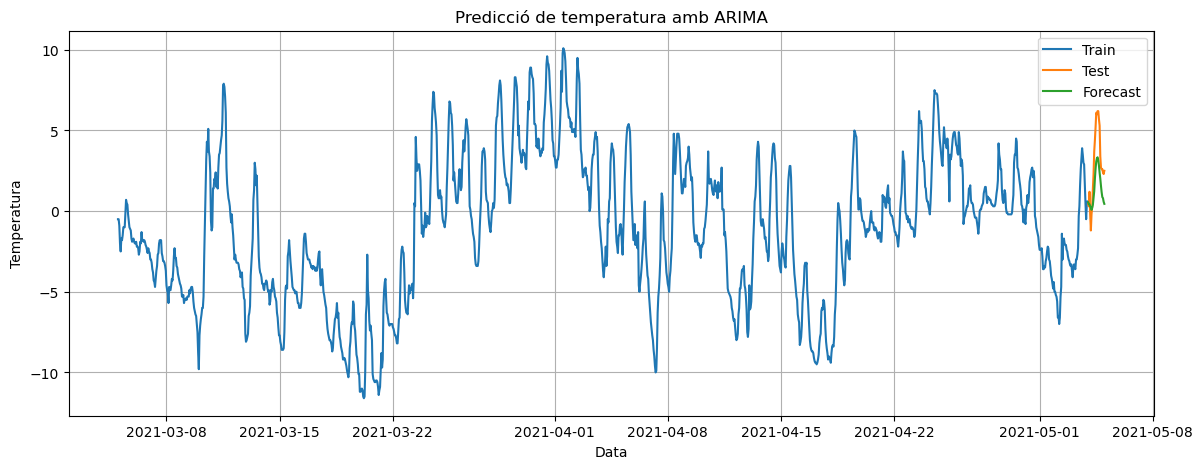

MAE: 1.67 °C
RMSE: 1.93 °C


In [ ]:
# Definim el període de predicció

inici = "2021-05-04 00:00:00+00:00"  
final = "2021-05-05 00:00:00+00:00"  

# Definim finestra d'entrenament (quant de temps enrere volem mirar)

dies_entrenament = 60  # entrenarem amb 90 dies previs (3 mesos)

# Parametres model  

p =  30     # Ordre autoregressiu (hores passades utilitzades per predir)
d =  2      # Ordre d'integració
q =  30     # Ordre de mitjana mòbil (nombre de errors passats utilitzats per predir)

arima_temp_tot (df, inici, final, dies_entrenament, p,d,q)


Dades d'entrenament: 19101 valors
Dades de test: 25 valors


,data,valor,forecast
0,2021-05-04 00:00:00+00:00,0.50,0.47
1,2021-05-04 01:00:00+00:00,0.30,0.30
2,2021-05-04 02:00:00+00:00,1.20,0.21
3,2021-05-04 03:00:00+00:00,-0.20,0.13
4,2021-05-04 04:00:00+00:00,-1.20,0.07


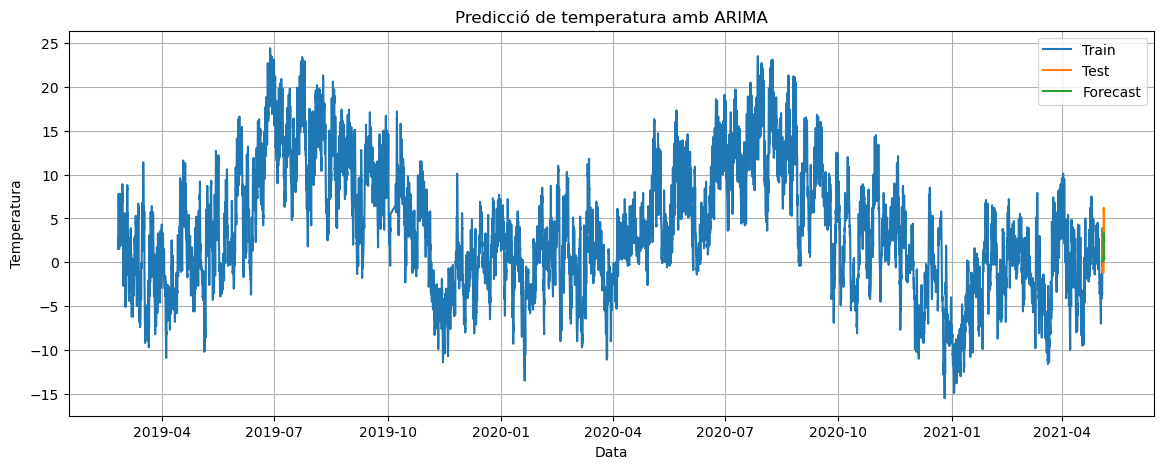

MAE: 1.62 °C
RMSE: 1.89 °C


In [17]:
# Definim el període de predicció

inici = "2021-05-04 00:00:00+00:00"  
final = "2021-05-05 00:00:00+00:00"  

# Definim finestra d'entrenament (quant de temps enrere volem mirar)

dies_entrenament = 800  # entrenarem amb 90 dies previs (3 mesos)

# Parametres model  

p =  30     # Ordre autoregressiu
d =  2      # Ordre d'integració
q =  30     # Ordre de mitjana mòbil

arima_temp (df, inici, final, dies_entrenament, p,d,q)

Dades d'entrenament: 240 valors
Dades de test: 25 valors


,data,valor,forecast
0,2021-02-01 00:00:00+00:00,-2.30,-2.85
1,2021-02-01 01:00:00+00:00,-2.50,-3.02
2,2021-02-01 02:00:00+00:00,-2.50,-3.31
3,2021-02-01 03:00:00+00:00,-3.10,-3.88
4,2021-02-01 04:00:00+00:00,-3.10,-5.01


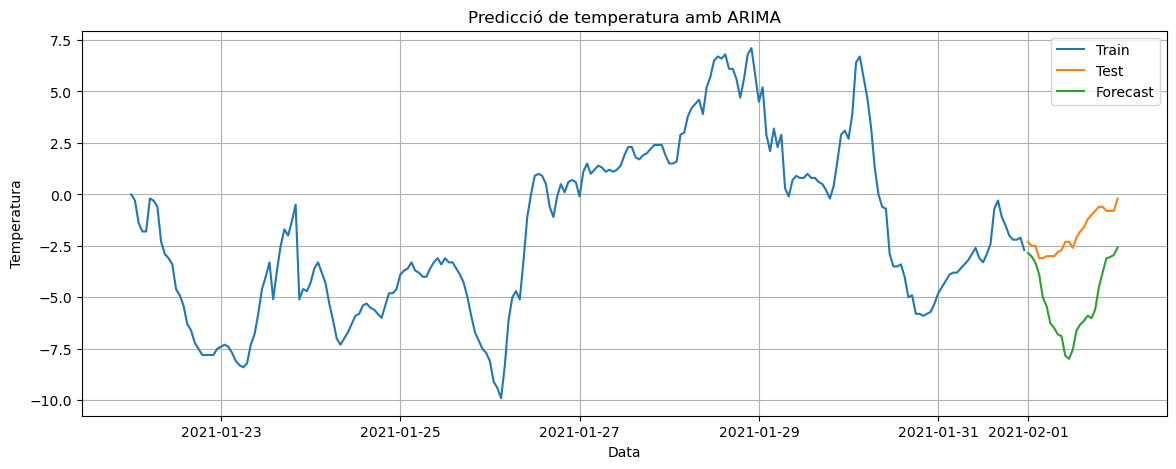

MAE: 3.29 °C
RMSE: 3.65 °C


In [10]:
# Definim el període de predicció

inici = "2021-02-01 00:00:00+00:00"  
final = "2021-02-02 00:00:00+00:00"  

# Definim finestra d'entrenament (quant de temps enrere volem mirar)

dies_entrenament = 10  # entrenarem amb 90 dies previs (3 mesos)

# Parametres model  

p =  60     # Ordre autoregressiu
d =  3      # Ordre d'integració
q =  40     # Ordre de mitjana mòbil

arima_temp (df, inici, final, dies_entrenament, p,d,q)


In [ ]:
rang_p = [0, 1, 2]
rang_d = [0, 1]
rang_q = [0, 1, 2]
data = df
inici = "2021-01-01 00:00:00+00:00"
final = "2021-01-02 00:00:00+00:00"
dies_entrenament = 4  # entrenarem amb 90 dies previs (3 mesos)

for p in rang_p:
    for d in rang_d:
        for q in rang_q:
            if (p, d, q) == (0, 0, 0):
                continue  # salta aquesta combinació
            print(f"\n--- Provant (p,d,q) = ({p},{d},{q}) ---")
            arima_temp(df, inici, final, dies_entrenament, p, d, q)

            
